# Time Series clustering with CNN autoencoders

![](https://timelyportfolio.github.io/rCharts_time_series/assets/fig/unnamed-chunk-4.png)

In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

import time_series_clustering as tsc

This notebook is an attempt to use a new methodology for clustering time series using ``autoencoders``. <br>
I will use Financial stock price data as test data for their easy accessibility. 


##### Various ideas : 
- Represent as an image with all metrics (open, high,low,etc...)
- Represent as an image with an aggregate by week/month 
- Which hyperparameters for the CNN (kernel size, pooling, etc...) that will have a real interpretation
- Use ``lucid`` library to visualize within the neural network
- Which preprocessing : normalization, difference, logreturns, etc...


##### To do 
- Larger window size from API

# Preparing the data

## Connecting with ``AlphaVantage`` API

Data available via the API https://www.alphavantage.co/

### Retrieve API KEY

In [2]:
import json
API_KEY = json.loads(open("c:/data/tokens.json").read())["ALPHA_VANTAGE"]

### Prepare a wrapper for the API

In [3]:
alpha = tsc.AlphaVantage(api_key=API_KEY)

In [4]:
aapl = alpha.get("AAPL")

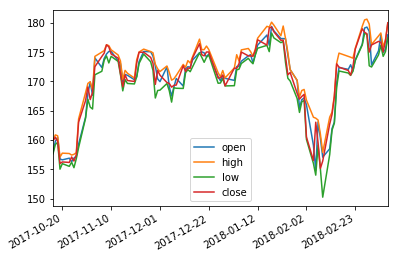

In [5]:
aapl.drop("volume",axis = 1).plot()
plt.show()

## Creating some wrappers

### Prepare a wrapper for the companies data

We will use ``cufflinks`` for easy plotting : http://web.quant-platform.com/trial/yves/Plotly_Cufflinks.html

In [6]:
tsc.init_notebook_mode(connected = True)

In [7]:
aapl = tsc.Company("AAPL",alpha = alpha)

In [8]:
aapl.plot(["open","close"])

### Prepare a wrapper for Companies

In [9]:
c = tsc.Companies(["AAPL","GOOG","MSFT"],alpha = alpha)

Acquiring data: 100%|████████████████████████████| 3/3 [00:01<00:00,  1.53it/s]
Acquiring data: 0it [00:00, ?it/s]


In [10]:
c.plot()

## Extracting data for a given list of companies

### Finding a list of tickers

The simplest way to gather a list of tickers on the web is simply using wikipedia. <br>
I will scrape the data in the page https://en.wikipedia.org/wiki/List_of_S%26P_500_companies to constitute the list

In [11]:
import requests
import bs4 as bs

In [12]:
page = bs.BeautifulSoup(requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies").content,"lxml")

In [13]:
rows = page.find("div",class_ = "mw-parser-output").find("table").findAll("tr")
tickers = pd.DataFrame([{"ticker":row.find("a").text,"link":row.find("a").attrs["href"]} for row in rows],columns = ["ticker","link"])
tickers = tickers.iloc[1:].reset_index(drop = True)

In [14]:
tickers.head(10)

,ticker,link
0,MMM,https://www.nyse.com/quote/XNYS:MMM
1,ABT,https://www.nyse.com/quote/XNYS:ABT
2,ABBV,https://www.nyse.com/quote/XNYS:ABBV
3,ACN,https://www.nyse.com/quote/XNYS:ACN
4,ATVI,http://www.nasdaq.com/symbol/atvi
5,AYI,https://www.nyse.com/quote/XNYS:AYI
6,ADBE,http://www.nasdaq.com/symbol/adbe
7,AMD,http://www.nasdaq.com/symbol/amd
8,AAP,https://www.nyse.com/quote/XNYS:AAP
9,AES,https://www.nyse.com/quote/XNYS:AES


### Extracting data for the list of symbols

In [15]:
sp = tsc.Companies(tickers = list(tickers.ticker),alpha = alpha)

Acquiring data: 100%|████████████████████████████| 1/1 [00:10<00:00, 10.66s/it]


In [136]:
sp

503 companies in the dataset

##### Saving and reloading

In [17]:
sp.save_as_json("sp500_stock_prices.json")

In [135]:
sp = tsc.Companies(json_path="sp500_stock_prices.json")

In [330]:
sp.plot(["MSFT","GOOG","AAPL"])

# Representing the data with a mono image

## Test with one-week mono image

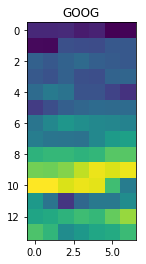

In [100]:
sp["GOOG"].show_mono_image()

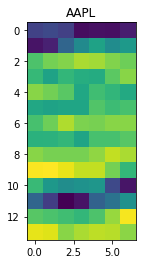

In [83]:
sp["AAPL"].show_mono_image()

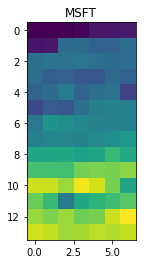

In [84]:
sp["MSFT"].show_mono_image()

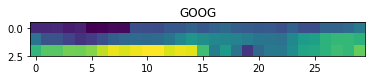

In [88]:
sp["GOOG"].show_mono_image(window = 30)

## Build the mono image dataset

In [137]:
data = sp.build_mono_image_dataset()

In [147]:
data = data.reshape(*data.shape,1)

In [154]:
data.shape

(503, 14, 7, 1)

# Creating a CNN  autoencoder

## Using Keras

https://blog.keras.io/building-autoencoders-in-keras.html

In [148]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

In [181]:
input_img = Input(shape=(16, 7, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [178]:
encoder = Model(input_img, encoded)

In [177]:
autoencoder.fit(data, data,
                epochs=500,
                batch_size=128,
                shuffle=True,verbose = 2) #,callbacks=[TQDMNotebookCallback(leave_inner=False)])

Epoch 1/500
 - 1s - loss: 0.6307
Epoch 2/500
 - 0s - loss: 0.6226
Epoch 3/500
 - 0s - loss: 0.6165
Epoch 4/500
 - 0s - loss: 0.6114
Epoch 5/500
 - 0s - loss: 0.6063
Epoch 6/500
 - 0s - loss: 0.6011
Epoch 7/500
 - 0s - loss: 0.5959
Epoch 8/500
 - 0s - loss: 0.5906
Epoch 9/500
 - 0s - loss: 0.5852
Epoch 10/500
 - 0s - loss: 0.5799
Epoch 11/500
 - 0s - loss: 0.5745
Epoch 12/500
 - 0s - loss: 0.5690
Epoch 13/500
 - 0s - loss: 0.5635
Epoch 14/500
 - 0s - loss: 0.5580
Epoch 15/500
 - 0s - loss: 0.5524
Epoch 16/500
 - 0s - loss: 0.5468
Epoch 17/500
 - 0s - loss: 0.5411
Epoch 18/500
 - 0s - loss: 0.5355
Epoch 19/500
 - 0s - loss: 0.5301
Epoch 20/500
 - 0s - loss: 0.5246
Epoch 21/500
 - 0s - loss: 0.5191
Epoch 22/500
 - 0s - loss: 0.5135
Epoch 23/500
 - 0s - loss: 0.5080
Epoch 24/500
 - 0s - loss: 0.5025
Epoch 25/500
 - 0s - loss: 0.4969
Epoch 26/500
 - 0s - loss: 0.4914
Epoch 27/500
 - 0s - loss: 0.4858
Epoch 28/500
 - 0s - loss: 0.4803
Epoch 29/500
 - 0s - loss: 0.4748
Epoch 30/500
 - 0s - lo

Epoch 238/500
 - 0s - loss: 0.3262
Epoch 239/500
 - 0s - loss: 0.3262
Epoch 240/500
 - 0s - loss: 0.3261
Epoch 241/500
 - 0s - loss: 0.3261
Epoch 242/500
 - 0s - loss: 0.3260
Epoch 243/500
 - 0s - loss: 0.3260
Epoch 244/500
 - 0s - loss: 0.3259
Epoch 245/500
 - 0s - loss: 0.3259
Epoch 246/500
 - 0s - loss: 0.3258
Epoch 247/500
 - 0s - loss: 0.3257
Epoch 248/500
 - 0s - loss: 0.3257
Epoch 249/500
 - 0s - loss: 0.3257
Epoch 250/500
 - 0s - loss: 0.3256
Epoch 251/500
 - 0s - loss: 0.3255
Epoch 252/500
 - 0s - loss: 0.3255
Epoch 253/500
 - 0s - loss: 0.3254
Epoch 254/500
 - 0s - loss: 0.3254
Epoch 255/500
 - 0s - loss: 0.3253
Epoch 256/500
 - 0s - loss: 0.3252
Epoch 257/500
 - 0s - loss: 0.3252
Epoch 258/500
 - 0s - loss: 0.3251
Epoch 259/500
 - 0s - loss: 0.3251
Epoch 260/500
 - 0s - loss: 0.3250
Epoch 261/500
 - 0s - loss: 0.3250
Epoch 262/500
 - 0s - loss: 0.3249
Epoch 263/500
 - 0s - loss: 0.3248
Epoch 264/500
 - 0s - loss: 0.3248
Epoch 265/500
 - 0s - loss: 0.3247
Epoch 266/500
 - 0s 

Epoch 472/500
 - 0s - loss: 0.3135
Epoch 473/500
 - 0s - loss: 0.3135
Epoch 474/500
 - 0s - loss: 0.3135
Epoch 475/500
 - 0s - loss: 0.3134
Epoch 476/500
 - 0s - loss: 0.3134
Epoch 477/500
 - 0s - loss: 0.3134
Epoch 478/500
 - 0s - loss: 0.3134
Epoch 479/500
 - 0s - loss: 0.3134
Epoch 480/500
 - 0s - loss: 0.3134
Epoch 481/500
 - 0s - loss: 0.3133
Epoch 482/500
 - 0s - loss: 0.3133
Epoch 483/500
 - 0s - loss: 0.3133
Epoch 484/500
 - 0s - loss: 0.3133
Epoch 485/500
 - 0s - loss: 0.3133
Epoch 486/500
 - 0s - loss: 0.3133
Epoch 487/500
 - 0s - loss: 0.3133
Epoch 488/500
 - 0s - loss: 0.3132
Epoch 489/500
 - 0s - loss: 0.3132
Epoch 490/500
 - 0s - loss: 0.3132
Epoch 491/500
 - 0s - loss: 0.3132
Epoch 492/500
 - 0s - loss: 0.3132
Epoch 493/500
 - 0s - loss: 0.3132
Epoch 494/500
 - 0s - loss: 0.3132
Epoch 495/500
 - 0s - loss: 0.3131
Epoch 496/500
 - 0s - loss: 0.3131
Epoch 497/500
 - 0s - loss: 0.3131
Epoch 498/500
 - 0s - loss: 0.3131
Epoch 499/500
 - 0s - loss: 0.3131
Epoch 500/500
 - 0s 

In [180]:
encoder.predict(data).shape

(503, 14, 7, 16)

## Using PyTorch

https://github.com/SherlockLiao/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py

In [186]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import os

In [282]:
autoencoder = tsc.Autoencoder()

In [283]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate,weight_decay=1e-5)

In [284]:
num_epochs = 1000
batch_size = 128
learning_rate = 1e-3

epoch [1000/1000], loss:0.0045

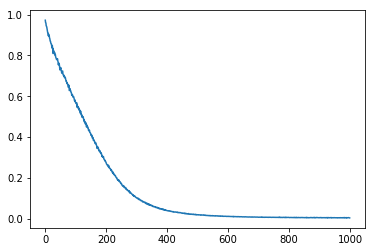

In [285]:
losses = []
for epoch in range(num_epochs):
    batch = data[np.random.randint(len(data),size = batch_size)]
    batch = Variable(torch.FloatTensor(batch))
    output = autoencoder(batch)
    loss = criterion(output, batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.data[0])
    print('\repoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data[0]),end = "")
    
plt.plot(losses)
plt.show()

# Check the results of the encoder

## Encoding with Autoencoder

In [294]:
encoded_data = autoencoder.encode(data).data.numpy()
encoded_data.shape

(503, 2, 9, 3)

In [301]:
encoded_data = encoded_data.reshape(len(encoded_data),-1)
encoded_data.shape

(503, 54)

## Embedding with TSNE the latent space

### TSNE embedding

In [302]:
from sklearn.manifold import TSNE

In [303]:
tsne = TSNE()

In [306]:
tsne_embedding = tsne.fit_transform(encoded_data)

In [320]:
tsne_embedding = pd.DataFrame(tsne_embedding,columns = ["x","y"])
tsne_embedding["company"] = [c.ticker for c in sp]
tsne_embedding.head(10)

,x,y,company
A,0.038104,-0.091569,A
AAL,0.038102,-0.091399,AAL
AAP,0.038104,-0.091570,AAP
AAPL,0.038104,-0.091570,AAPL
ABBV,0.038104,-0.091570,ABBV
ABC,0.038104,-0.091570,ABC
ABT,0.038104,-0.091570,ABT
ACN,0.038104,-0.091570,ACN
ADBE,0.038104,-0.091570,ADBE
ADI,0.038104,-0.091570,ADI


In [321]:
tsne_embedding.iplot(kind = "scatter",x = "x",y = "y",text = "company",mode = "markers+text")

### Verification

In [329]:
sp.plot(tickers=["SWK","CVX"])

In [328]:
sp.plot(tickers=["MS","LMT","HIG"])